In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os, sys
cwd = os.getcwd()

api_path_mnist = os.path.join(cwd, '..', 'tools', 'mnist_utils')
api_path_sampling = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_gan_metrics = os.path.join(cwd, '..', 'tools', 'gan_metrics')
models_mnist_scratch_path = os.path.join(cwd, '..', 'models', 'models_mnist')
sys.path.append(api_path_mnist)
sys.path.append(api_path_sampling)
sys.path.append(api_path_gan_metrics)

In [36]:
import numpy as np
import time
import random
import glob
import importlib
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from distributions import IndependentNormal
import torchvision.transforms as transforms
import torchvision.datasets as dset

from dcgan import Discriminator, Generator

from functools import partial

from general_utils import to_var, DotDict, to_np, Discriminator_logits

from mh_sampling import mh_sampling, mh_sampling_from_scratch
from ebm_sampling import (langevin_sampling, 
                          aggregate_sampling_output,
                          load_data_from_batches,
                          mala_sampling,
                          tempered_transitions_sampling,
                          gan_energy)

from sir_ais_sampling import (sir_independent_sampling,
                              sir_correlated_sampling)

from metrics import inception_score

# Test model from https://github.com/csinva/gan-vae-pretrained-pytorch

In [12]:
d_path = os.path.join(models_mnist_scratch_path, "netD_epoch_99.pth")
g_path = os.path.join(models_mnist_scratch_path, "netG_epoch_99.pth")
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
dckpt = torch.load(d_path, map_location=device)
gckpt = torch.load(g_path, map_location=device)

In [13]:
D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

D.load_state_dict(dckpt)
G.load_state_dict(gckpt)

G = G.to(device)
D = D.to(device)

In [14]:
G

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)

In [15]:
D

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [37]:
D_logits = Discriminator_logits(D, ngpu=1).eval()

In [39]:
D_logits

Discriminator_logits(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [16]:
batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
fake_images = G(fixed_noise)

In [33]:
print(fake_images.shape)
print(fake_images.min())
print(fake_images.max())

torch.Size([25, 1, 28, 28])
tensor(-1., device='cuda:1', grad_fn=<MinBackward1>)
tensor(1., device='cuda:1', grad_fn=<MaxBackward1>)


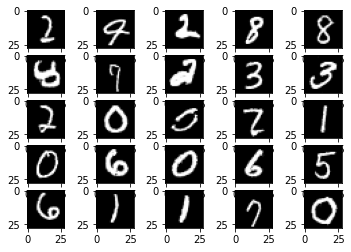

In [17]:
fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)

R, C = 5, 5

for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

In [18]:
outputs = D(fake_images)
print(outputs)

tensor([0.0405, 0.1090, 0.3614, 0.2001, 0.6874, 0.3836, 0.5414, 0.2225, 0.3506,
        0.0042, 0.0140, 0.0694, 0.0360, 0.0086, 0.2340, 0.1434, 0.4716, 0.1425,
        0.6848, 0.4596, 0.6760, 0.2893, 0.4173, 0.7261, 0.2212],
       device='cuda:1', grad_fn=<SqueezeBackward1>)


In [38]:
D_logits(fake_images).sigmoid()

tensor([0.0405, 0.1090, 0.3614, 0.2001, 0.6874, 0.3836, 0.5414, 0.2225, 0.3506,
        0.0042, 0.0140, 0.0694, 0.0360, 0.0086, 0.2340, 0.1434, 0.4716, 0.1425,
        0.6848, 0.4596, 0.6760, 0.2893, 0.4173, 0.7261, 0.2212],
       device='cuda:1', grad_fn=<SigmoidBackward>)

# Exloring MNIST dataset

In [24]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)

batchSize = 64

imageSize = 28

path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'

dataset = dset.MNIST(root=path_to_save, download=True,
                   transform=transforms.Compose([
                       transforms.Resize(imageSize),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,)),
                   ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=4)

Extracting /home/daniil/gans-mcmc/saved_numpy_arrays/MNIST/raw/train-images-idx3-ubyte.gz to /home/daniil/gans-mcmc/saved_numpy_arrays/MNIST/raw


Extracting /home/daniil/gans-mcmc/saved_numpy_arrays/MNIST/raw/train-labels-idx1-ubyte.gz to /home/daniil/gans-mcmc/saved_numpy_arrays/MNIST/raw


Extracting /home/daniil/gans-mcmc/saved_numpy_arrays/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/daniil/gans-mcmc/saved_numpy_arrays/MNIST/raw



Extracting /home/daniil/gans-mcmc/saved_numpy_arrays/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/daniil/gans-mcmc/saved_numpy_arrays/MNIST/raw
Processing...
Done!


/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [30]:
data_arr = []
for images, labels in dataloader:
    print(images.min())
    print(images.max())
    print(images.shape)
    break

tensor(-1.)
tensor(1.)
torch.Size([64, 1, 28, 28])


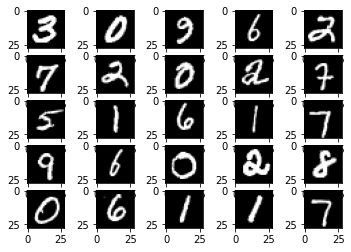

In [32]:
real_images_np = images.cpu().detach().numpy()
real_images_np = real_images_np.reshape(real_images_np.shape[0], 28, 28)

R, C = 5, 5

for i in range(25):
    plt.subplot(R, C, i + 1)
    plt.imshow(real_images_np[i], cmap='gray')
plt.show()

In [35]:
data_arr = []
for images, labels in dataloader:
    data_arr.append(images)
    
all_train_data = torch.cat(data_arr)
print(all_train_data.shape)

torch.Size([60000, 1, 28, 28])


# ULA

In [40]:
z_dim = 100
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

def z_transform(z):
    return z.unsqueeze(-1).unsqueeze(-1)

log_prob = True
normalize_to_0_1 = True
target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D_logits, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob,
                     z_transform = z_transform)

In [50]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 1000
n = 60000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'ula_mnist'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 10
continue_z = None

z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z,
                                  n_steps, grad_step, eps_scale)

  2%|▏         | 1/60 [00:22<22:33, 22.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_0.npy was saved, file shape = (11, 1000, 100)


  3%|▎         | 2/60 [00:46<22:15, 23.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1000.npy was saved, file shape = (11, 1000, 100)


  5%|▌         | 3/60 [01:09<22:01, 23.18s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2000.npy was saved, file shape = (11, 1000, 100)


  7%|▋         | 4/60 [01:33<21:52, 23.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3000.npy was saved, file shape = (11, 1000, 100)


  8%|▊         | 5/60 [01:58<21:42, 23.68s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4000.npy was saved, file shape = (11, 1000, 100)


 10%|█         | 6/60 [02:22<21:28, 23.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5000.npy was saved, file shape = (11, 1000, 100)


 12%|█▏        | 7/60 [02:46<21:11, 23.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6000.npy was saved, file shape = (11, 1000, 100)


 13%|█▎        | 8/60 [03:10<20:51, 24.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7000.npy was saved, file shape = (11, 1000, 100)


 15%|█▌        | 9/60 [03:35<20:30, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8000.npy was saved, file shape = (11, 1000, 100)


 17%|█▋        | 10/60 [03:59<20:09, 24.18s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9000.npy was saved, file shape = (11, 1000, 100)


 18%|█▊        | 11/60 [04:23<19:45, 24.20s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_10000.npy was saved, file shape = (11, 1000, 100)


 20%|██        | 12/60 [04:47<19:20, 24.19s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_11000.npy was saved, file shape = (11, 1000, 100)


 22%|██▏       | 13/60 [05:11<18:56, 24.17s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_12000.npy was saved, file shape = (11, 1000, 100)


 23%|██▎       | 14/60 [05:36<18:31, 24.16s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_13000.npy was saved, file shape = (11, 1000, 100)


 25%|██▌       | 15/60 [06:00<18:07, 24.16s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_14000.npy was saved, file shape = (11, 1000, 100)


 27%|██▋       | 16/60 [06:24<17:42, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_15000.npy was saved, file shape = (11, 1000, 100)


 28%|██▊       | 17/60 [06:48<17:17, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_16000.npy was saved, file shape = (11, 1000, 100)


 30%|███       | 18/60 [07:12<16:53, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_17000.npy was saved, file shape = (11, 1000, 100)


 32%|███▏      | 19/60 [07:36<16:28, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_18000.npy was saved, file shape = (11, 1000, 100)


 33%|███▎      | 20/60 [08:00<16:04, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_19000.npy was saved, file shape = (11, 1000, 100)


 35%|███▌      | 21/60 [08:24<15:40, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_20000.npy was saved, file shape = (11, 1000, 100)


 37%|███▋      | 22/60 [08:49<15:16, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_21000.npy was saved, file shape = (11, 1000, 100)


 38%|███▊      | 23/60 [09:13<14:52, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_22000.npy was saved, file shape = (11, 1000, 100)


 40%|████      | 24/60 [09:37<14:29, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_23000.npy was saved, file shape = (11, 1000, 100)


 42%|████▏     | 25/60 [10:01<14:05, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_24000.npy was saved, file shape = (11, 1000, 100)


 43%|████▎     | 26/60 [10:25<13:41, 24.15s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_25000.npy was saved, file shape = (11, 1000, 100)


 45%|████▌     | 27/60 [10:49<13:17, 24.15s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_26000.npy was saved, file shape = (11, 1000, 100)


 47%|████▋     | 28/60 [11:13<12:52, 24.15s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_27000.npy was saved, file shape = (11, 1000, 100)


 48%|████▊     | 29/60 [11:38<12:28, 24.16s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_28000.npy was saved, file shape = (11, 1000, 100)


 50%|█████     | 30/60 [12:02<12:04, 24.16s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_29000.npy was saved, file shape = (11, 1000, 100)


 52%|█████▏    | 31/60 [12:26<11:40, 24.16s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_30000.npy was saved, file shape = (11, 1000, 100)


 53%|█████▎    | 32/60 [12:50<11:16, 24.16s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_31000.npy was saved, file shape = (11, 1000, 100)


 55%|█████▌    | 33/60 [13:14<10:52, 24.15s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_32000.npy was saved, file shape = (11, 1000, 100)


 57%|█████▋    | 34/60 [13:38<10:27, 24.15s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_33000.npy was saved, file shape = (11, 1000, 100)


 58%|█████▊    | 35/60 [14:03<10:03, 24.15s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_34000.npy was saved, file shape = (11, 1000, 100)


 60%|██████    | 36/60 [14:27<09:39, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_35000.npy was saved, file shape = (11, 1000, 100)


 62%|██████▏   | 37/60 [14:51<09:15, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_36000.npy was saved, file shape = (11, 1000, 100)


 63%|██████▎   | 38/60 [15:15<08:51, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_37000.npy was saved, file shape = (11, 1000, 100)


 65%|██████▌   | 39/60 [15:39<08:26, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_38000.npy was saved, file shape = (11, 1000, 100)


 67%|██████▋   | 40/60 [16:03<08:02, 24.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_39000.npy was saved, file shape = (11, 1000, 100)


 68%|██████▊   | 41/60 [16:27<07:38, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_40000.npy was saved, file shape = (11, 1000, 100)


 70%|███████   | 42/60 [16:51<07:14, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_41000.npy was saved, file shape = (11, 1000, 100)


 72%|███████▏  | 43/60 [17:16<06:50, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_42000.npy was saved, file shape = (11, 1000, 100)


 73%|███████▎  | 44/60 [17:40<06:26, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_43000.npy was saved, file shape = (11, 1000, 100)


 75%|███████▌  | 45/60 [18:04<06:01, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_44000.npy was saved, file shape = (11, 1000, 100)


 77%|███████▋  | 46/60 [18:28<05:37, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_45000.npy was saved, file shape = (11, 1000, 100)


 78%|███████▊  | 47/60 [18:52<05:13, 24.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_46000.npy was saved, file shape = (11, 1000, 100)


 80%|████████  | 48/60 [19:16<04:49, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_47000.npy was saved, file shape = (11, 1000, 100)


 82%|████████▏ | 49/60 [19:40<04:25, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_48000.npy was saved, file shape = (11, 1000, 100)


 83%|████████▎ | 50/60 [20:04<04:01, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_49000.npy was saved, file shape = (11, 1000, 100)


 85%|████████▌ | 51/60 [20:29<03:37, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_50000.npy was saved, file shape = (11, 1000, 100)


 87%|████████▋ | 52/60 [20:53<03:12, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_51000.npy was saved, file shape = (11, 1000, 100)


 88%|████████▊ | 53/60 [21:17<02:48, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_52000.npy was saved, file shape = (11, 1000, 100)


 90%|█████████ | 54/60 [21:41<02:24, 24.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_53000.npy was saved, file shape = (11, 1000, 100)


 92%|█████████▏| 55/60 [22:05<02:00, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_54000.npy was saved, file shape = (11, 1000, 100)


 93%|█████████▎| 56/60 [22:29<01:36, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_55000.npy was saved, file shape = (11, 1000, 100)


 95%|█████████▌| 57/60 [22:53<01:12, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_56000.npy was saved, file shape = (11, 1000, 100)


 97%|█████████▋| 58/60 [23:17<00:48, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_57000.npy was saved, file shape = (11, 1000, 100)


 98%|█████████▊| 59/60 [23:41<00:24, 24.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_58000.npy was saved, file shape = (11, 1000, 100)


100%|██████████| 60/60 [24:06<00:00, 24.10s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_mnist_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_59000.npy was saved, file shape = (11, 1000, 100)


In [51]:
batch_size = 1000
n = 60000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'ula_mnist'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'

load_ula_batches = load_data_from_batches(n, batch_size, path_to_save, file_name)

100%|██████████| 60/60 [00:00<00:00, 1117.42it/s]


In [52]:
load_ula_batches.shape

(11, 60000, 100)